In [1]:
import os, random
from unicodedata import name
import pandas as pd
import numpy as np
import scipy.stats as stats
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from model import APANET, APAData
from train_script import build_dataloaders
import pickle
# from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import seqlogo
import logomaker
from pathlib import Path

In [2]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [3]:
MODELS_ROOT = '/data/users/goodarzilab/aiden/projects/APA/codes/CNN_MATTs/APA-Net_2024_05_08_v2/model_outs/significant/'
DATA_ROOT = '/data/users/goodarzilab/aiden/projects/APA/input_data/2024_rev/22May/significant/'

In [4]:
def plot_filter_logos(filters):
        outname = "filter_" + str(filter) + ".png"
        for i in range(len(filters)):
            fig, ax = plt.subplots(1, 1, figsize=(10, 10))
            cpm = seqlogo.CompletePM(filters[i], alphabet_type='RNA')
            outname = "logs/" + cpm.consensus + "{}_.png".format(i)
            # seqlogo.seqlogo the filter for each ax[i]
            seqlogo.seqlogo(cpm, ax=ax[i], ic_scale=False, format='png', size='medium')
            # save the figure
            plt.savefig(outname)
    
def test_performance(model, test_data_loader, device):
    target_list, pred_list = [], []
    valid_loss, valid_R = 0.0, 0.0
    cells_res = {}
    model.eval()
    # make a empty torch tensor to save the filters of the first conv layer
    filters = []
    with torch.no_grad():
        for batch_idx, batch in enumerate(test_data_loader):
            seq_X, celltype, celltype_name, Y = batch
            out = model(seq_X, celltype)
            # filters:
            # get the filters of the first conv layer
            filters.append(model.conv_block_1.op[0].weight.data)
        stacked_activations = torch.stack(filters, dim=0).to(device)
        print("stacked_activations shape: ", stacked_activations.shape)
        mean_activations = torch.mean(stacked_activations, dim=0).to(device)
        print("mean_activations shape: ", mean_activations.shape)
        #
        ## lets turn the activatoions into RNA pwms
        ppms = F.softmax(mean_activations, dim=1)
        # loop over the filters and save in a list:
        filter_lst = []
        for filter in range(ppms.shape[0]):
            filter_lst.append(ppms[filter,:,:].cpu().numpy())
        # plot the filters:
        plot_filter_logos(filter_lst)

In [5]:
window=12
window_left = int(window/2)
window_right = window - window_left
Threshold=0.7
filter_pwms = {'filter_{}'.format(i):[] for i in range(128)}
count_matrix = {'filter_{}'.format(i):[] for i in range(128)}

In [6]:
# initialize the model
config = {
        "batch_size":64,
        "epochs": 512,
        "project_name": 'test_performace',
        "device": 'cuda:01',
        "opt": "Adam",
        "loss": "mse",
        "lr": 2.5e-05,
        "adam_weight_decay": 0.09, # 0.06 before
        "conv1kc": 128, #128, 64
        "conv1ks": 12,
        "conv1st": 1,
        "pool1ks": 16,
        "pool1st": 16,
        "cnvpdrop1": 0,
        "Matt_heads": 8,
        "Matt_drop": 0.2,
        "fc1_dims": [
            8192, # 8192, 5120
            4048,
            1024,
            512,
            256,
        ],  # first dimension will be calculated dynamically
        "fc1_dropouts": [0.25, 0.25, 0.25, 0, 0],
        "fc2_dims": [128, 32, 16, 1],  # first dimension will be calculated dynamically
        "fc2_dropouts": [0.2, 0.2, 0, 0],
        'psa_query_dim': 128, # make sure this is correct
        'psa_num_layers': 1,
        'psa_nhead': 1,
        'psa_dim_feedforward':1024,
        'psa_dropout': 0 
    }

def get_model(model_path='model.pth'):
    model = APANET(config)
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cuda:1')))
    model.eval()
    return model
model = get_model(f'{MODELS_ROOT}/model_out_fold4.pt').to('cuda:1')
model

APANET(
  (conv_block_1): ConvBlock(
    (op): Sequential(
      (0): Conv1d(4, 128, kernel_size=(12,), stride=(1,), padding=(6,))
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0)
      (3): MaxPool1d(kernel_size=16, stride=16, padding=0, dilation=1, ceil_mode=False)
      (4): Dropout(p=0, inplace=False)
    )
  )
  (attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
  )
  (fc1): FCBlock(
    (op): Sequential(
      (0): Linear(in_features=32000, out_features=8192, bias=True)
      (1): BatchNorm1d(8192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.25, inplace=False)
      (4): Linear(in_features=8192, out_features=4048, bias=True)
      (5): BatchNorm1d(4048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): Dropout(p=0.25, inplace=False)
  

In [7]:
test_data = np.load(f'{DATA_ROOT}test_fold_4.npy', allow_pickle=True)
_, test_loader = build_dataloaders(
        'cuda:1',
        test_data,
        test_data,
        config["batch_size"],
    )

In [9]:
epsilon = 1e-10
FILTER_ROOT = f'{MODELS_ROOT}filters/'
# Ensure the models directory exists
Path(FILTER_ROOT).mkdir(parents=True, exist_ok=True)

# Function to extract and weight sub-sequences
def extract_weighted_subsequences(seq_X, fmap, filter_index, window_left, window_right):
    dat_idx, position_idx = np.where(fmap[:, filter_index, :] > np.max(fmap[:, filter_index, :]) * 0.5)
    sub_seqs = []
    weights = []

    for i in range(len(dat_idx)):
        start_window = position_idx[i] - window_left
        if start_window < 0:
            start_buffer = np.zeros((4, -start_window))
            start = 0
        else:
            start = start_window

        end_window = position_idx[i] + window_right
        if end_window > seq_X.shape[2]:
            end_buffer = np.zeros((4, end_window - seq_X.shape[2]))
            end = seq_X.shape[2]
        else:
            end = end_window

        sub_seq = seq_X[dat_idx[i], :, start:end]

        if start_window < 0:
            sub_seq = np.hstack([start_buffer, sub_seq])
        if end_window > seq_X.shape[2]:
            sub_seq = np.hstack([sub_seq, end_buffer])

        weight = fmap[dat_idx[i], filter_index, start:end]
        weight = weight[np.newaxis, :]  # Add the channel dimension

        if weight.shape[1] < sub_seq.shape[1]:
            weight = np.hstack([weight, np.zeros((1, sub_seq.shape[1] - weight.shape[1]))])
        elif weight.shape[1] > sub_seq.shape[1]:
            sub_seq = np.hstack([sub_seq, np.zeros((4, weight.shape[1] - sub_seq.shape[1]))])

        sub_seq = sub_seq * weight
        sub_seqs.append(sub_seq)
        weights.append(np.ones((4, sub_seq.shape[1])) * weight)

    return np.array(sub_seqs), np.array(weights)

# Function to normalize and save PWMs
def normalize_and_save_pwms(filter_pwms, count_matrix, filter_name, num):
    if filter_pwms.size > 0:
        sum_filter_pwms = np.sum(filter_pwms, axis=0)
        sum_count_matrix = np.sum(count_matrix, axis=0) + epsilon  # Add epsilon to prevent division by zero

        normalized_pwm = sum_filter_pwms / sum_count_matrix
        filter_pwms = normalized_pwm
        filter_pwms[np.isnan(filter_pwms)] = 0

        # Save the processed filter
        with open(f'{FILTER_ROOT}/filters_{num}_pwms_5cv_APANET_threshold0.5_28May.pkl', 'wb') as handle:
            pickle.dump({filter_name: filter_pwms}, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Main processing function
def process_filters(model, test_loader, window_left, window_right):
    with torch.no_grad():
        for filter_index in range(128):
            filter_name = f'filter_{filter_index}'
            print(f"Processing filter number: {filter_index + 1}")

            filter_pwms = []
            count_matrix = []

            for batch_idx, batch in enumerate(test_loader):
                seq_X, Y, celltype, celltype_name, _ = batch
                feature_map = model.conv_block_1.op[0](seq_X.to('cuda:1'))
                fmap = feature_map.cpu().detach().numpy()
                seq_X = seq_X.cpu().detach().numpy()

                sub_seqs, weights = extract_weighted_subsequences(seq_X, fmap, filter_index, window_left, window_right)

                filter_pwms.extend(sub_seqs)
                count_matrix.extend(weights)

            filter_pwms = np.array(filter_pwms)
            count_matrix = np.array(count_matrix)

            normalize_and_save_pwms(filter_pwms, count_matrix, filter_name, filter_index)

# Parameters
window = 12
window_left = int(window / 2)
window_right = window - window_left

# Assume model and test_loader are already defined
process_filters(model, test_loader, window_left, window_right)

Processing filter number: 1


Processing filter number: 2
Processing filter number: 3
Processing filter number: 4
Processing filter number: 5
Processing filter number: 6
Processing filter number: 7
Processing filter number: 8
Processing filter number: 9
Processing filter number: 10
Processing filter number: 11
Processing filter number: 12
Processing filter number: 13
Processing filter number: 14
Processing filter number: 15
Processing filter number: 16
Processing filter number: 17
Processing filter number: 18
Processing filter number: 19
Processing filter number: 20
Processing filter number: 21
Processing filter number: 22
Processing filter number: 23
Processing filter number: 24
Processing filter number: 25
Processing filter number: 26
Processing filter number: 27
Processing filter number: 28
Processing filter number: 29
Processing filter number: 30
Processing filter number: 31
Processing filter number: 32
Processing filter number: 33
Processing filter number: 34
Processing filter number: 35
Processing filter numb

In [20]:
# a function to make MEME file for  filters
def make_meme_file(filter_pwms, date):
    """Takes in a dictionary of filter pwms and writes a meme file"""
    with open(f'{MODELS_ROOT}/filter_pwms_{date}.meme', 'w') as f:
        f.write('MEME version 4\n\n')
        f.write('ALPHABET= ACGU\n\n')
        f.write('strands: + -\n\n')
        f.write('Background letter frequencies (from uniform background):\n')
        f.write('A 0.25000 C 0.25000 G 0.25000 U 0.25000\n\n')
        for i in range(len(filter_pwms)):
            # call your plotting function with the current dataframe and the subplot
            filter_name = 'filter_'+str(i)
            tst_filter = filter_pwms[filter_name]
            tst_filter[tst_filter < 0] = 0
            # Nan to zero
            tst_filter = pd.DataFrame(tst_filter.T, columns=['A','C','G','U'])
            tst_filter = tst_filter.apply(normalize_row_n, axis=1)
            tst_filter[np.isnan(tst_filter)] = 0.25
            f.write('MOTIF {}\n'.format(filter_name))
            f.write('letter-probability matrix: alength= 4 w= 12 nsites= 20 E= 0\n')
            for row in tst_filter.values:
                f.write(' '.join([str(x) for x in row])+'\n')
            f.write('\n')
    return

def normalize_row_n(row):
    max_val = row.max()
    other_vals = row[row != max_val]
    if other_vals.empty or all(other_vals >= 0.4 * max_val):
        return row / row.sum()
    else:
        # If there is a value less than 0.2 * max_val, modify the row
        # scale and then normalize the row
        small_vals = other_vals[other_vals < 0.2 * max_val]
        if not small_vals.empty:
            max_val += small_vals.sum()
            row[row.isin(small_vals)] = 0
            row[row == row.max()] = max_val
        return row / row.sum()

    
def plot_filter_processed_pwms(filter_pwms, name):
    """Takes in a dictionary of filter pwms and plots them in a 16x8 grid"""
    n_rows = 16
    n_cols = 8

    fig = plt.figure(figsize=(20, 20))

    for i in range(n_rows):
        for j in range(n_cols):
            # calculate the index of the current dataframe in the list
            df_index = i * n_cols + j
            
            if df_index >= 128:
                # if we have processed all the dataframes, break out of the loop
                break
            
            # create a subplot for the current index
            ax = fig.add_subplot(n_rows, n_cols, df_index + 1)
            
            # call your plotting function with the current dataframe and the subplot
            filter_name = 'filter_'+str(df_index)
            tst_filter = filter_pwms[filter_name]
            tst_filter[tst_filter < 0] = 0
            # Nan to zero
            tst_filter = pd.DataFrame(tst_filter.T, columns=['A','C','G','U'])
            tst_filter = tst_filter.apply(normalize_row_n, axis=1)
            tst_filter[np.isnan(tst_filter)] = 0.25
            logomaker.Logo(tst_filter,
                        shade_below=.5,
                        fade_below=.5,
                        font_name='Arial Rounded MT Bold',
                        ax=ax)
            ax.set_title(filter_name)

    plt.tight_layout()
    # plt.show()
    fig.savefig(f'{MODELS_ROOT}/APANET_filter_logos_processed.pdf', format='pdf')
    return plt

def plot_filter_raw_pwms(filter_pwms, name):
    """Takes in a dictionary of filter pwms and plots them in a 16x8 grid"""
    n_rows = 16
    n_cols = 8

    fig = plt.figure(figsize=(20, 20))

    for i in range(n_rows):
        for j in range(n_cols):
            # calculate the index of the current dataframe in the list
            df_index = i * n_cols + j
            
            if df_index >= 128:
                # if we have processed all the dataframes, break out of the loop
                break
            
            # create a subplot for the current index
            ax = fig.add_subplot(n_rows, n_cols, df_index + 1)
            
            # call your plotting function with the current dataframe and the subplot
            filter_name = 'filter_'+str(df_index)
            tst_filter = filter_pwms[filter_name]
            tst_filter[tst_filter < 0] = 0
            # Nan to zero
            tst_filter = pd.DataFrame(tst_filter.T, columns=['A','C','G','U'])
            logomaker.Logo(tst_filter,
                        shade_below=.5,
                        fade_below=.5,
                        font_name='Arial Rounded MT Bold',
                        ax=ax)
            ax.set_title(filter_name)

    plt.tight_layout()
    plt.show()
    fig.savefig(f'{MODELS_ROOT}/APANET_filter_logos_raw.pdf', format='pdf')
    return plt

In [17]:
filter_pwms = {}
for i in range(128):
    with open(f'{MODELS_ROOT}/filters/filters_{i}_pwms_5cv_APANET_threshold0.5_28May.pkl', 'rb') as handle:
        tmp = pickle.load(handle)
    name = f'filter_{i}'
    filter_pwms[name] = tmp[name]

findfont: Font family 'Arial Rounded MT Bold' not found.
findfont: Font family 'Arial Rounded MT Bold' not found.
findfont: Font family 'Arial Rounded MT Bold' not found.
findfont: Font family 'Arial Rounded MT Bold' not found.
findfont: Font family 'Arial Rounded MT Bold' not found.
findfont: Font family 'Arial Rounded MT Bold' not found.
findfont: Font family 'Arial Rounded MT Bold' not found.
findfont: Font family 'Arial Rounded MT Bold' not found.
findfont: Font family 'Arial Rounded MT Bold' not found.
findfont: Font family 'Arial Rounded MT Bold' not found.
findfont: Font family 'Arial Rounded MT Bold' not found.
findfont: Font family 'Arial Rounded MT Bold' not found.
findfont: Font family 'Arial Rounded MT Bold' not found.
findfont: Font family 'Arial Rounded MT Bold' not found.
findfont: Font family 'Arial Rounded MT Bold' not found.
findfont: Font family 'Arial Rounded MT Bold' not found.
findfont: Font family 'Arial Rounded MT Bold' not found.
findfont: Font family 'Arial Ro

<module 'matplotlib.pyplot' from '/data/users/goodarzilab/aiden/anaconda3/envs/for_DL/lib/python3.10/site-packages/matplotlib/pyplot.py'>

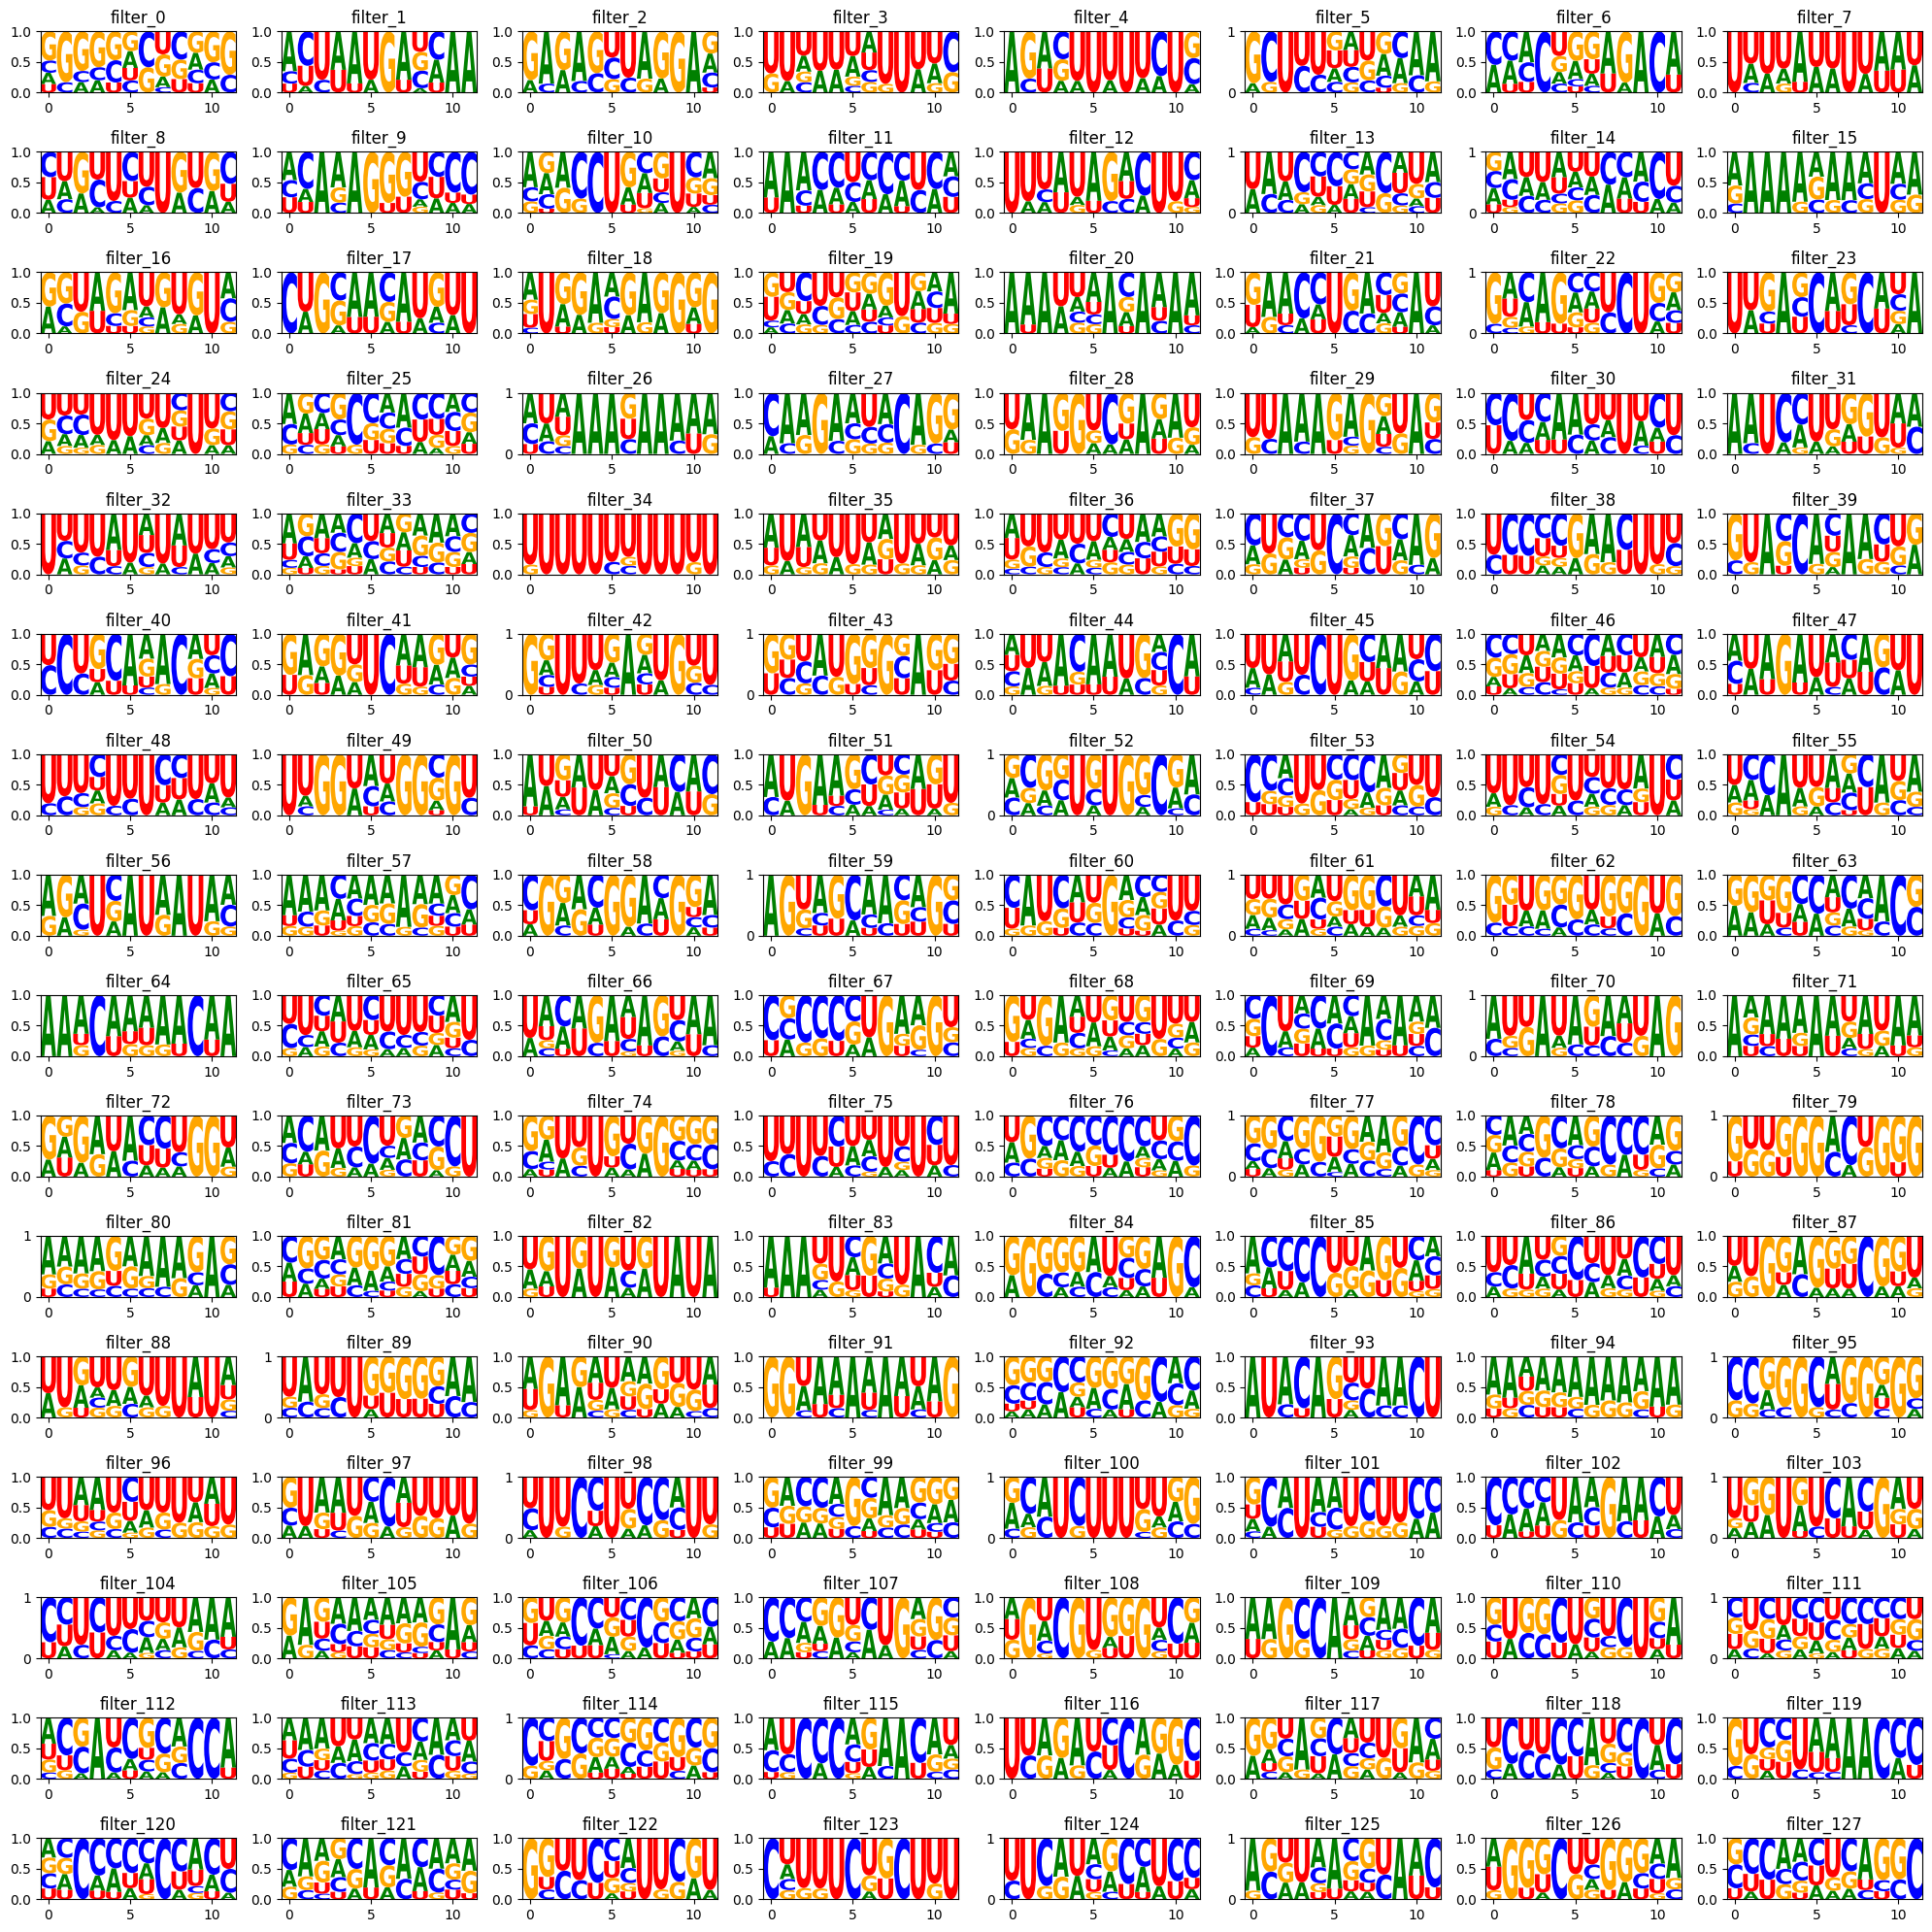

In [19]:
plot_filter_processed_pwms(filter_pwms, 'All_cts_processed')

In [21]:
make_meme_file(filter_pwms, '28_May_2024')

findfont: Font family 'Arial Rounded MT Bold' not found.
findfont: Font family 'Arial Rounded MT Bold' not found.
findfont: Font family 'Arial Rounded MT Bold' not found.
findfont: Font family 'Arial Rounded MT Bold' not found.
findfont: Font family 'Arial Rounded MT Bold' not found.
findfont: Font family 'Arial Rounded MT Bold' not found.
findfont: Font family 'Arial Rounded MT Bold' not found.
findfont: Font family 'Arial Rounded MT Bold' not found.
findfont: Font family 'Arial Rounded MT Bold' not found.
findfont: Font family 'Arial Rounded MT Bold' not found.
findfont: Font family 'Arial Rounded MT Bold' not found.
findfont: Font family 'Arial Rounded MT Bold' not found.
findfont: Font family 'Arial Rounded MT Bold' not found.
findfont: Font family 'Arial Rounded MT Bold' not found.
findfont: Font family 'Arial Rounded MT Bold' not found.
findfont: Font family 'Arial Rounded MT Bold' not found.
findfont: Font family 'Arial Rounded MT Bold' not found.
findfont: Font family 'Arial Ro

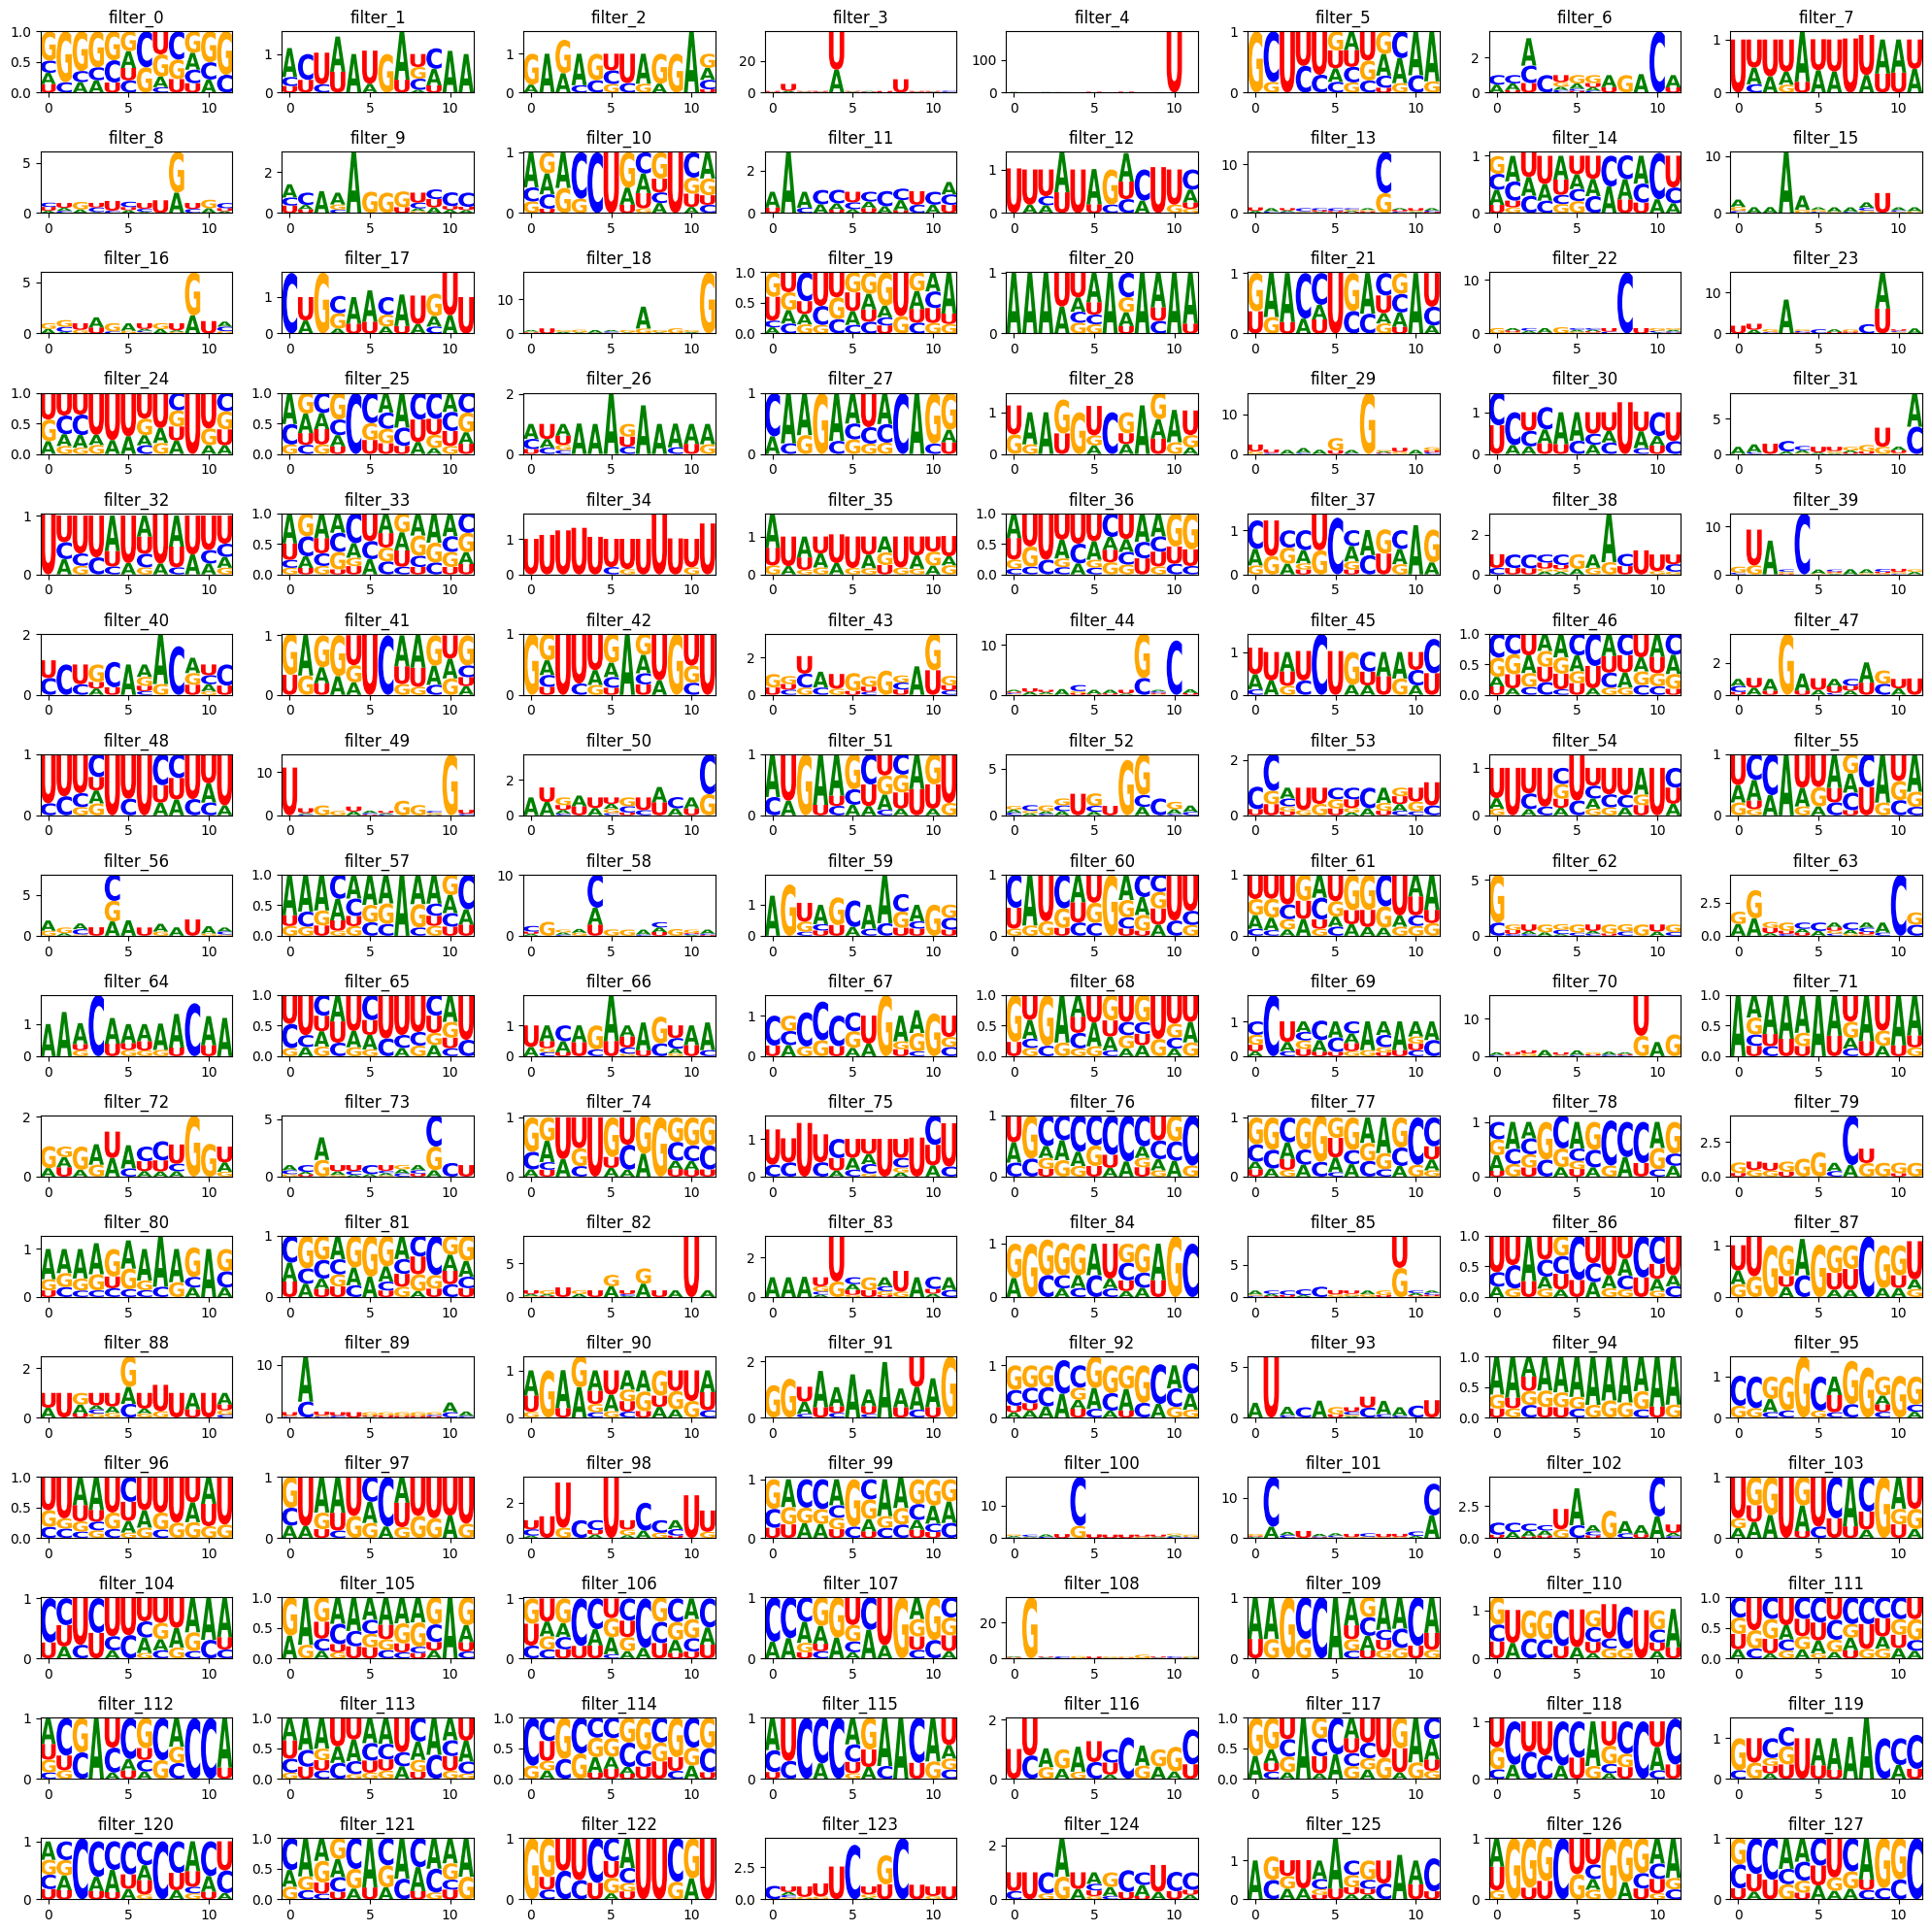

<module 'matplotlib.pyplot' from '/data/users/goodarzilab/aiden/anaconda3/envs/for_DL/lib/python3.10/site-packages/matplotlib/pyplot.py'>

In [22]:
plot_filter_raw_pwms(filter_pwms, 'All_cts_processed')